# Job Description Multi-Label Classification
This project implements a machine learning pipeline to classify job descriptions into multiple categories based on responses to a set of predefined questions. The model is trained using a multi-label classification approach, leveraging the XGBoost algorithm wrapped in a MultiOutputClassifier to handle the multiple outputs. The project also includes hyperparameter tuning using GridSearchCV to optimize model performance.


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\nosao\Desktop\spacyProj\spacy_venv\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Job Description: To provide an effective Joinery resource to ensure the University fabric is efficiently maintained...
Predicted Responses: {'Question 7': 'B', 'Question 8': 'C', 'Question 9': 'D', 'Question 10': 'C', 'Question 11': 'B'}
Accuracy: 0.6500
Precision: 0.6571
Recall: 0.6279
F1 Score: 0.5418


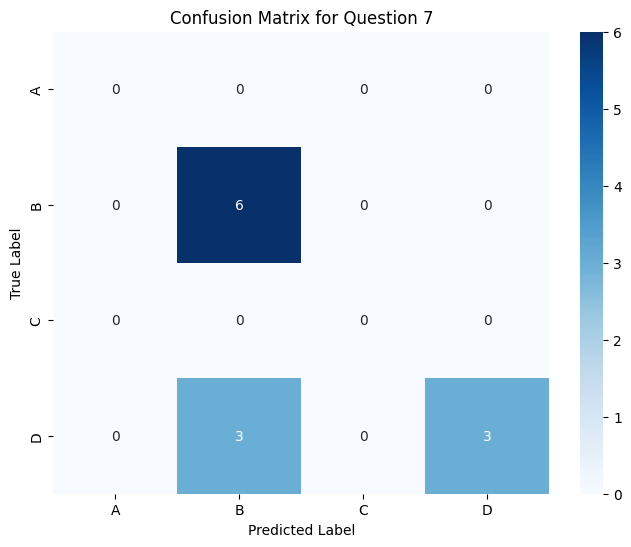

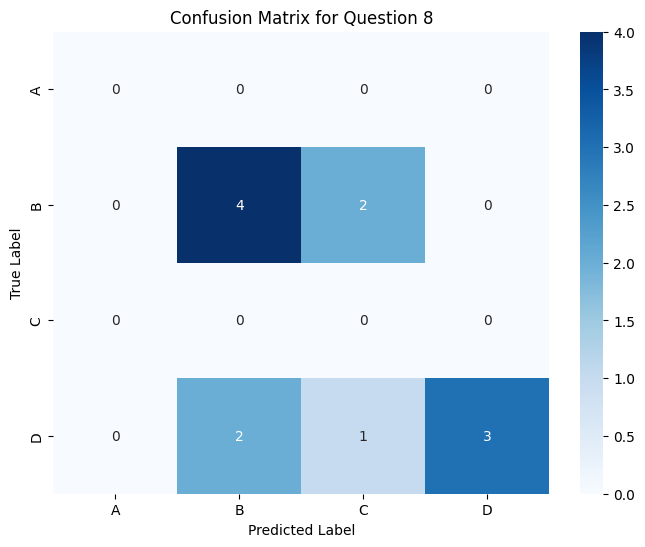

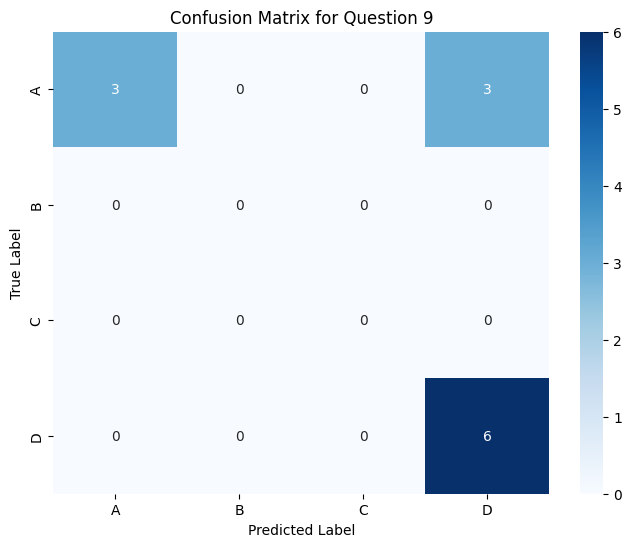

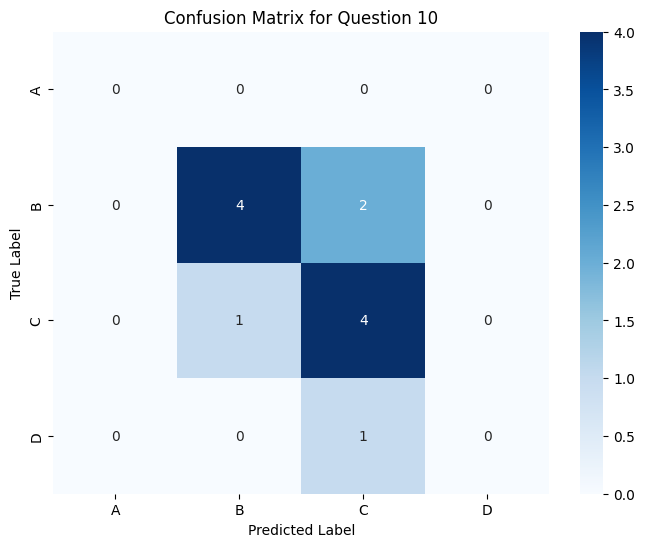

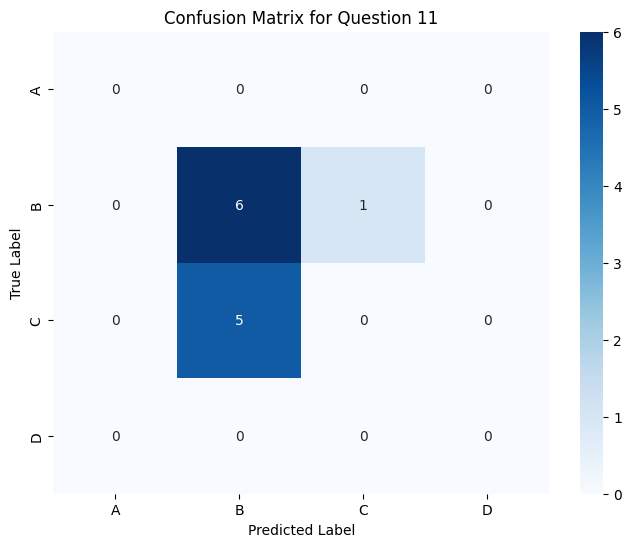

In [20]:
# pip is a package manager for Python libraries, and we use it to install the required libraries for this project.
!pip install pandas scikit-learn seaborn

# Import necessary libraries for data manipulation, feature extraction, model training, and evaluation
import pandas as pd  # For data manipulation and analysis
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text data into TF-IDF features
from sklearn.multioutput import MultiOutputClassifier  # For multi-label classification
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting classifier
from sklearn.model_selection import train_test_split, GridSearchCV  # For data splitting and hyperparameter tuning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # For model evaluation metrics

# Step 1: Load the dataset
# The dataset is a CSV file containing job descriptions and responses to multiple questions.
file_path = 'C:/Users/nosao/Desktop/Maxwell-Text Classification/Target Response/data/Target Response DB.csv'
df = pd.read_csv(file_path)

# Step 2: Encode the responses
# We map the responses ('A', 'B', 'C', 'D') to integers (0, 1, 2, 3) to make them compatible with the machine learning model.
response_columns = ['Question 7', 'Question 8', 'Question 9', 'Question 10', 'Question 11']
df_encoded = df.copy()

response_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}  # Mapping from response labels to integers
reverse_mapping = {v: k for k, v in response_mapping.items()}  # Reverse mapping for decoding predictions later
for col in response_columns:
    df_encoded[col] = df_encoded[col].map(response_mapping)  # Apply the mapping to each response column

# Step 3: Split data into features and labels
# 'Job description' serves as the feature (X), and the responses to the questions are the labels (y).
X = df_encoded['Job description']  # Feature: job descriptions
y = df_encoded[response_columns]  # Labels: encoded responses to each question

# Step 4: Text Preprocessing and Vectorization
# Convert the job descriptions into TF-IDF features. We use bigrams and remove common English stopwords.
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')  # Configured to use bigrams and remove stopwords
X_vectorized = vectorizer.fit_transform(X)  # Apply the vectorizer to the job descriptions

# Step 5: Split data into training and testing sets
# The data is split into training (80%) and testing (20%) sets for model evaluation.
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Step 6: Define the base model
# Here we use a Gradient Boosting classifier as our base model.
base_model = GradientBoostingClassifier(random_state=42)

# Step 7: Define the hyperparameters grid for tuning
# We specify a grid of hyperparameters to tune using GridSearchCV.
param_grid = {
    'estimator__n_estimators': [50, 100],  # Number of boosting stages
    'estimator__learning_rate': [0.05, 0.1],  # Learning rate shrinks the contribution of each tree
    'estimator__max_depth': [3, 5]  # Maximum depth of the individual estimators
}

# Step 8: Initialize and run Grid Search
# We use GridSearchCV to find the best hyperparameters for the model.
grid_search = GridSearchCV(MultiOutputClassifier(base_model), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Fit the model using the training data

# Step 9: Obtain the best model from grid search
best_model = grid_search.best_estimator_  # Retrieve the best model found by GridSearchCV

# Step 10: Predict on the test set
# Use the best model to make predictions on the test data.
y_pred = best_model.predict(X_test)

# Step 11: Convert predictions to a DataFrame for easy manipulation
predictions = pd.DataFrame(y_pred, columns=response_columns)
for col in response_columns:
    predictions[col] = predictions[col].map(reverse_mapping)  # Decode the predictions back to the original labels

# Step 12: Initialize dictionaries to store evaluation metrics
# We evaluate accuracy, precision, recall, and F1 score for each question.
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Step 13: Calculate evaluation metrics for each question
for col in response_columns:
    y_test_col = y_test[col].map(reverse_mapping)  # Decode the test labels
    metrics['accuracy'].append(accuracy_score(y_test_col, predictions[col]))  # Accuracy
    metrics['precision'].append(precision_score(y_test_col, predictions[col], average='macro', zero_division=1))  # Precision
    metrics['recall'].append(recall_score(y_test_col, predictions[col], average='macro', zero_division=1))  # Recall
    metrics['f1'].append(f1_score(y_test_col, predictions[col], average='macro', zero_division=1))  # F1 Score

# Step 14: Average the metrics across all questions
avg_metrics = {metric: sum(values) / len(values) for metric, values in metrics.items()}  # Average the metrics

# Step 15: Define a function to adjust predictions based on a custom rule
# This function adjusts the predictions such that once an 'A' is found, all preceding responses are set to 'D'.
def adjust_predictions(predictions):
    for index, row in predictions.iterrows():
        main_focus_found = False
        for col in reversed(predictions.columns):
            if main_focus_found:
                predictions.at[index, col] = 'D'  # Mark all preceding questions as 'D'
            if row[col] == 'A':
                main_focus_found = True
    return predictions

# Step 16: Adjust predictions using the custom rule
adjusted_predictions = adjust_predictions(predictions.copy())

# Step 17: Example prediction for a new job description
new_description = ["To provide an effective Joinery resource to ensure the University fabric is efficiently maintained..."]
new_description_vectorized = vectorizer.transform(new_description)
predictions_new = best_model.predict(new_description_vectorized)

# Decode the predictions for the new description
predictions_new_df = pd.DataFrame(predictions_new, columns=response_columns)
for col in response_columns:
    predictions_new_df[col] = predictions_new_df[col].map(reverse_mapping)

# Adjust the new predictions based on the custom rule
adjusted_predictions_new = adjust_predictions(predictions_new_df.copy())

# Print the job description and its predicted responses
print("Job Description:", new_description[0])
print("Predicted Responses:", adjusted_predictions_new.iloc[0].to_dict())

# Print evaluation metrics for the model
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"F1 Score: {avg_metrics['f1']:.4f}")

# Step 18: Visualize the performance using confusion matrices
# This example shows how to generate and visualize confusion matrices for the predicted responses.

from sklearn.metrics import confusion_matrix  # For generating confusion matrices
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For better visualizations


# Generate confusion matrices for all questions and plot them
for question in response_columns:
    y_test_col = y_test[question].map(reverse_mapping)
    y_pred_col = predictions[question]
    
    cm = confusion_matrix(y_test_col, y_pred_col, labels=['A', 'B', 'C', 'D'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
    plt.title(f'Confusion Matrix for {question}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
